In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import matplotlib

In [4]:
from sklearn.decomposition import PCA
import numpy as np

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
from sklearn.model_selection import cross_val_score

In [8]:
#subset = ['Home','teamPF_T6_x','teamFT%_T6_x','teamBLKR_T6_x','teamPPS_T6_x','teamEDiff_T6_x','teamSTL/TO_T6_x','teamTREB%_T6_y',
 #'teamBLKR_T6_y','teamPPS_T6_y','teamAST/TO_T6_y','teamSTL/TO_T6_y']

## Next test is to change the trailing averages of the original data and compare r2 results at different trailing amounts
#### From results above, I don't know which features will be more signficant if you increase/decrease trailing average so will use PCA on all variables
##### therefore at each trailling average amount I will:
- Standardize X values
- Transform X Values with PCA at .95 level
- Predict target variable with components at different levels of alpha within Cross Validated Logistic Regression
- visualize results

In [160]:
nba = pd.read_csv('2017-18_teamBoxScore.csv')
nba.head()

,PrimKey,opptKey,gmDate,teamAbbr,teamLoc,teamRslt,teamMin,teamDayOff,teamPTS,teamAST,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,43025BOS,43025CLE,10/17/2017,BOS,Away,Loss,241,0,99,24,...,55.5208,101.7143,98.7227,2.9916,0.4176,14.6154,1.1176,17.6471,100.2809,99.8648
1,43025CLE,43025BOS,10/17/2017,CLE,Home,Win,240,0,102,19,...,62.5519,98.7227,101.7143,-2.9916,0.3956,17.7778,2.0000,91.6667,100.2809,100.2809
2,43025HOU,43025GS,10/17/2017,HOU,Away,Win,239,0,122,28,...,86.2033,118.0353,119.0108,-0.9755,0.4725,24.2442,2.0000,29.4118,102.5117,102.9406
3,43025GS,43025HOU,10/17/2017,GS,Home,Loss,241,0,121,34,...,81.9038,119.0108,118.0353,0.9755,0.4700,19.1309,2.1538,69.2308,102.5117,102.0863
4,43026CHA,43026DET,10/18/2017,CHA,Away,Loss,238,0,90,16,...,70.7113,103.0506,90.9270,12.1236,0.4271,17.8731,2.6667,155.5556,98.9805,99.8123


In [161]:
nba['teamRslt'] = pd.get_dummies(nba['teamRslt'])

In [162]:
#select columns that are numeric for trailing calc
nba_numbers = nba.select_dtypes(exclude='object')
a = pd.DataFrame(nba['PrimKey'])
nba_numbers = nba_numbers.merge(a,left_index=True, right_index=True)
nba_numbers.head()

,teamRslt,teamMin,teamDayOff,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,...,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace,PrimKey
0,1,241,0,99,24,12,11,4,24,88,...,101.7143,98.7227,2.9916,0.4176,14.6154,1.1176,17.6471,100.2809,99.8648,43025BOS
1,0,240,0,102,19,17,3,4,25,83,...,98.7227,101.7143,-2.9916,0.3956,17.7778,2.0000,91.6667,100.2809,100.2809,43025CLE
2,0,239,0,122,28,13,9,5,16,97,...,118.0353,119.0108,-0.9755,0.4725,24.2442,2.0000,29.4118,102.5117,102.9406,43025HOU
3,1,241,0,121,34,17,5,9,25,80,...,119.0108,118.0353,0.9755,0.4700,19.1309,2.1538,69.2308,102.5117,102.0863,43025GS
4,1,238,0,90,16,17,4,3,15,73,...,103.0506,90.9270,12.1236,0.4271,17.8731,2.6667,155.5556,98.9805,99.8123,43026CHA


In [163]:
num_fields = nba_numbers.columns.tolist()

In [164]:
#exclude fields that don't make sense to do a trailing average of
exclude = ['teamDayOff']
team_fields = [x for x in num_fields if x not in exclude]
#exclude opponent stats as it is redudant 
#as there is a line for the same game for the opponent too and 
#will merge that back later
team_fields = [x for x in team_fields if 'oppt' not in x]

In [165]:
#remove PrimKey
trailing_fields = [x for x in team_fields if x != 'PrimKey']

In [166]:
len(trailing_fields)

45

In [167]:
#get team names for loop below
teams = nba['teamAbbr'].unique()
len(teams) #correct should be 30

30

In [168]:
nba['Win?'] = 1 - nba['teamRslt']

In [169]:
nba['teamRslt'] = 1 - nba['teamRslt']

In [170]:
#create final set to merge with
#home/away, days off, and the dependent variable Win/loss


nba['MarginOfVictory'] = nba['teamPTS'] - nba['opptPTS']
#dummy home
home = pd.get_dummies(nba['teamLoc'])
home = home['Home']
nba['Home'] = home
#final selection
nba_final = nba[['PrimKey','opptKey','teamAbbr','MarginOfVictory','teamDayOff','Home', 'Win?']]
nba_final = nba_final.merge(nba[['PrimKey','teamDayOff']], left_on='opptKey', right_on='PrimKey')
nba_final.drop(columns='PrimKey_y', inplace=True)
nba_final.head()

,PrimKey_x,opptKey,teamAbbr,MarginOfVictory,teamDayOff_x,Home,Win?,teamDayOff_y
0,43025BOS,43025CLE,BOS,-3,0,0,0,0
1,43025CLE,43025BOS,CLE,3,0,1,1,0
2,43025HOU,43025GS,HOU,1,0,0,1,0
3,43025GS,43025HOU,GS,-1,0,1,0,0
4,43026CHA,43026DET,CHA,-12,0,0,0,0


In [171]:
nba_final.columns = nba_final.columns.str.replace('PrimKey_x', 'PrimKey')

In [172]:
nba_final.head()

,PrimKey,opptKey,teamAbbr,MarginOfVictory,teamDayOff_x,Home,Win?,teamDayOff_y
0,43025BOS,43025CLE,BOS,-3,0,0,0,0
1,43025CLE,43025BOS,CLE,3,0,1,1,0
2,43025HOU,43025GS,HOU,1,0,0,1,0
3,43025GS,43025HOU,GS,-1,0,1,0,0
4,43026CHA,43026DET,CHA,-12,0,0,0,0


In [173]:
nba_final = nba_final.merge(nba[team_fields], left_on='PrimKey',right_on='PrimKey')

In [174]:
nba_final.shape

(2460, 53)

In [175]:
nba_final.head()

,PrimKey,opptKey,teamAbbr,MarginOfVictory,teamDayOff_x,Home,Win?,teamDayOff_y,teamRslt,teamMin,...,teamFIC40,teamOrtg,teamDrtg,teamEDiff,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,poss,pace
0,43025BOS,43025CLE,BOS,-3,0,0,0,0,0,241,...,62.5519,98.7227,101.7143,-2.9916,0.3956,17.7778,2.0000,91.6667,100.2809,99.8648
1,43025CLE,43025BOS,CLE,3,0,1,1,0,1,240,...,55.5208,101.7143,98.7227,2.9916,0.4176,14.6154,1.1176,17.6471,100.2809,100.2809
2,43025HOU,43025GS,HOU,1,0,0,1,0,1,239,...,81.9038,119.0108,118.0353,0.9755,0.4700,19.1309,2.1538,69.2308,102.5117,102.9406
3,43025GS,43025HOU,GS,-1,0,1,0,0,0,241,...,86.2033,118.0353,119.0108,-0.9755,0.4725,24.2442,2.0000,29.4118,102.5117,102.0863
4,43026CHA,43026DET,CHA,-12,0,0,0,0,0,238,...,49.4748,90.9270,103.0506,-12.1236,0.3333,13.4725,0.9412,23.5294,98.9805,99.8123


In [176]:
nba_final.columns

Index(['PrimKey', 'opptKey', 'teamAbbr', 'MarginOfVictory', 'teamDayOff_x',
       'Home', 'Win?', 'teamDayOff_y', 'teamRslt', 'teamMin', 'teamPTS',
       'teamAST', 'teamTO', 'teamSTL', 'teamBLK', 'teamPF', 'teamFGA',
       'teamFGM', 'teamFG%', 'team2PA', 'team2PM', 'team2P%', 'team3PA',
       'team3PM', 'team3P%', 'teamFTA', 'teamFTM', 'teamFT%', 'teamORB',
       'teamDRB', 'teamTRB', 'teamTREB%', 'teamASST%', 'teamTS%', 'teamEFG%',
       'teamOREB%', 'teamDREB%', 'teamTO%', 'teamSTL%', 'teamBLK%', 'teamBLKR',
       'teamPPS', 'teamFIC', 'teamFIC40', 'teamOrtg', 'teamDrtg', 'teamEDiff',
       'teamPlay%', 'teamAR', 'teamAST/TO', 'teamSTL/TO', 'poss', 'pace'],
      dtype='object')

In [177]:
z = [print(x, ',', sep='', end='') for x in team_fields]

teamRslt,teamMin,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,team2PA,team2PM,team2P%,team3PA,team3PM,team3P%,teamFTA,teamFTM,teamFT%,teamORB,teamDRB,teamTRB,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,teamTO%,teamSTL%,teamBLK%,teamBLKR,teamPPS,teamFIC,teamFIC40,teamOrtg,teamDrtg,teamEDiff,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,poss,pace,PrimKey,

In [178]:
z = [print(x, ',', sep='', end='') for x in trailing_fields]

teamRslt,teamMin,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,team2PA,team2PM,team2P%,team3PA,team3PM,team3P%,teamFTA,teamFTM,teamFT%,teamORB,teamDRB,teamTRB,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,teamTO%,teamSTL%,teamBLK%,teamBLKR,teamPPS,teamFIC,teamFIC40,teamOrtg,teamDrtg,teamEDiff,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,poss,pace,

In [179]:
team_fields = team_fields + ['opptKey','teamAbbr','MarginOfVictory', 'Home','teamDayOff_x','teamDayOff_y','Win?']

In [180]:
trailing_fields.append('MarginOfVictory')

In [181]:
team_fields.append('Win%')

In [193]:
#create home/away winning percentage over total amount of games previous in season

# Settings
pd.options.mode.chained_assignment = None

counter = 0
for x in teams:
    for j in [0,1]:
        df = nba_final[['PrimKey','Home','Win?']][nba_final['teamAbbr']==x][nba_final['Home']==j]
        df['Win%'] = np.nan
        # Fill the new column with values
        for i in range(df.shape[0]):
            if i == 0:
                df['Win%'].iloc[i] = np.nan
            else:
                df['Win%'].iloc[i] = df['Win?'].iloc[:i].shift().mean()
        if counter == 0:
            newDF = df
        else:
            newDF = newDF.append(df)
        counter = 1

In [194]:
newDF.shape

(2460, 4)

In [196]:
nba_final.shape

(2460, 54)

In [186]:
nba_final.head()

,PrimKey,opptKey,teamAbbr,MarginOfVictory,teamDayOff_x,Home,Win?,teamDayOff_y,teamRslt,teamMin,...,teamFIC40,teamOrtg,teamDrtg,teamEDiff,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,poss,pace
0,43025BOS,43025CLE,BOS,-3,0,0,0,0,0,241,...,62.5519,98.7227,101.7143,-2.9916,0.3956,17.7778,2.0000,91.6667,100.2809,99.8648
1,43025CLE,43025BOS,CLE,3,0,1,1,0,1,240,...,55.5208,101.7143,98.7227,2.9916,0.4176,14.6154,1.1176,17.6471,100.2809,100.2809
2,43025HOU,43025GS,HOU,1,0,0,1,0,1,239,...,81.9038,119.0108,118.0353,0.9755,0.4700,19.1309,2.1538,69.2308,102.5117,102.9406
3,43025GS,43025HOU,GS,-1,0,1,0,0,0,241,...,86.2033,118.0353,119.0108,-0.9755,0.4725,24.2442,2.0000,29.4118,102.5117,102.0863
4,43026CHA,43026DET,CHA,-12,0,0,0,0,0,238,...,49.4748,90.9270,103.0506,-12.1236,0.3333,13.4725,0.9412,23.5294,98.9805,99.8123


In [195]:
nba_final = nba_final.merge(newDF[['PrimKey','Win%']], left_on='PrimKey', right_on='PrimKey')

In [197]:
nba_final.head()

,PrimKey,opptKey,teamAbbr,MarginOfVictory,teamDayOff_x,Home,Win?,teamDayOff_y,teamRslt,teamMin,...,teamOrtg,teamDrtg,teamEDiff,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,poss,pace,Win%
0,43025BOS,43025CLE,BOS,-3,0,0,0,0,0,241,...,98.7227,101.7143,-2.9916,0.3956,17.7778,2.0000,91.6667,100.2809,99.8648,NaN
1,43025CLE,43025BOS,CLE,3,0,1,1,0,1,240,...,101.7143,98.7227,2.9916,0.4176,14.6154,1.1176,17.6471,100.2809,100.2809,NaN
2,43025HOU,43025GS,HOU,1,0,0,1,0,1,239,...,119.0108,118.0353,0.9755,0.4700,19.1309,2.1538,69.2308,102.5117,102.9406,NaN
3,43025GS,43025HOU,GS,-1,0,1,0,0,0,241,...,118.0353,119.0108,-0.9755,0.4725,24.2442,2.0000,29.4118,102.5117,102.0863,NaN
4,43026CHA,43026DET,CHA,-12,0,0,0,0,0,238,...,90.9270,103.0506,-12.1236,0.3333,13.4725,0.9412,23.5294,98.9805,99.8123,NaN


In [198]:
nba_final.columns

Index(['PrimKey', 'opptKey', 'teamAbbr', 'MarginOfVictory', 'teamDayOff_x',
       'Home', 'Win?', 'teamDayOff_y', 'teamRslt', 'teamMin', 'teamPTS',
       'teamAST', 'teamTO', 'teamSTL', 'teamBLK', 'teamPF', 'teamFGA',
       'teamFGM', 'teamFG%', 'team2PA', 'team2PM', 'team2P%', 'team3PA',
       'team3PM', 'team3P%', 'teamFTA', 'teamFTM', 'teamFT%', 'teamORB',
       'teamDRB', 'teamTRB', 'teamTREB%', 'teamASST%', 'teamTS%', 'teamEFG%',
       'teamOREB%', 'teamDREB%', 'teamTO%', 'teamSTL%', 'teamBLK%', 'teamBLKR',
       'teamPPS', 'teamFIC', 'teamFIC40', 'teamOrtg', 'teamDrtg', 'teamEDiff',
       'teamPlay%', 'teamAR', 'teamAST/TO', 'teamSTL/TO', 'poss', 'pace',
       'Win%'],
      dtype='object')

In [139]:
def trailAvg(df, trailAmt, teams, team_fields, trailing_fields):
    final_df = df[['PrimKey', 'opptKey']]
    #compute trailing average
    counter = 0
    for i in teams:
        for j in [0,1]:
            temp = df[team_fields][df['teamAbbr']==i][df['Home']==j]
            for x in trailing_fields:
                temp[x+'_T'+str(trailAmt)] = temp[x].shift().rolling(window=trailAmt, min_periods = trailAmt).median()
            if counter == 0:
                newDF = temp
            else:
                newDF = newDF.append(temp)
            counter = 1
        
    #create list with only trailing fields
    fields_t = [x for x in newDF.columns.tolist() if '_T' in x]
    fields_oppt = ['PrimKey','Win%'] + fields_t
    fields_team = ['PrimKey','MarginOfVictory','Win?', 'Home','teamDayOff_x','teamDayOff_y','Win%'] + fields_t
    
    #left join/merge with final nba sample which has only unique games with MoV, Home/Away, Days 
    df_final = final_df.merge(newDF[fields_team], how='left', left_on='PrimKey', right_on='PrimKey')
    df_final = df_final.merge(newDF[fields_oppt], how='left', left_on='opptKey',right_on='PrimKey')
    
    #remove nas and clean up duplicate columns/column names
    df_final.dropna(axis = 0, how='any', inplace=True)
    df_final.drop(columns='PrimKey_y', inplace=True)
    df_final.columns = df_final.columns.str.replace('PrimKey_x', 'PrimKey')
    df_final.reset_index(inplace=True,drop=True)
    
    #remove every other row
    home = 0
    away = 0
    for i in range(0,len(df_final),2):
        if home == away:
            df_final.drop(i,0,inplace=True)
            away += 1
        elif home < away:
            df_final.drop(i+1,0,inplace=True)
            home += 1
        elif home > away:
            df_final.drop(i,0,inplace=True)
            away += 1  
    df_final.reset_index(inplace=True,drop=True)
    

    return df_final

In [199]:
nba_6 = trailAvg(nba_final, 6, teams, team_fields, trailing_fields)

In [200]:
nba_6.head()

,PrimKey,opptKey,MarginOfVictory,Win?,Home,teamDayOff_x,teamDayOff_y,Win%_x,teamRslt_T6_x,teamMin_T6_x,...,teamOrtg_T6_y,teamDrtg_T6_y,teamEDiff_T6_y,teamPlay%_T6_y,teamAR_T6_y,teamAST/TO_T6_y,teamSTL/TO_T6_y,poss_T6_y,pace_T6_y,MarginOfVictory_T6_y
0,43048DEN,43048OKC,8,1,1,2,2,0.600000,1.0,240.0,...,103.82730,99.34290,-3.54825,0.42745,14.07520,1.33240,83.48415,95.69955,95.50285,-3.5
1,43049ATL,43049DET,-7,0,0,3,2,0.166667,0.0,240.0,...,112.16320,100.91940,10.90405,0.45145,18.06065,1.68335,56.66670,97.78410,97.47880,10.5
2,43049POR,43049BKN,-4,0,1,3,3,0.666667,0.5,240.5,...,97.73345,111.55630,-7.55260,0.37705,14.91675,1.18750,49.00000,109.09360,108.64090,-8.5
3,43050ATL,43050WAS,-19,0,0,1,2,0.285714,0.0,239.5,...,114.71730,112.50705,-1.06495,0.46110,15.86850,1.51655,37.50000,100.20125,100.42465,-1.0
4,43050NY,43050SAC,27,1,1,3,1,0.666667,1.0,240.5,...,100.16500,110.35085,-14.15420,0.41400,14.62700,1.33330,53.33330,92.24275,92.43085,-13.0


In [203]:
X_Cols = [x for x in nba_6.columns.tolist() if '_x' in x or '_y' in x]
X_Cols.append('Home')

In [204]:
X = scale_PCA(nba_6[X_Cols])

In [205]:
LR = LogisticRegression(penalty='l2', solver='lbfgs')
scores = cross_val_score(LR, X, nba_6['Win?'], cv=5)

In [206]:
scores.mean()

0.6563703024957646

In [47]:
#write function to standardize X values and PCA Transform
def scale_PCA(X):
    X1 = X.astype(float)
    scaler = StandardScaler()
    X_S = scaler.fit_transform(X1)
    pca1 = PCA(.95)
    pca1.fit(X_S)
    X_PCA = pca1.transform(X_S)
    return X_PCA

In [85]:
#function for logistic regularization
def logisticReg(x, Y, Kfolds):
    LR = LogisticRegression(penalty='l2', solver='lbfgs')
    scores = cross_val_score(LR, x, Y, cv=Kfolds)
    #print()
    #print('Best Alpha: {}\nr2 of {:5.5f}'.format(alphaLst[results.index(bestScore)],bestScore))
    return scores.mean()

In [27]:
#write function to call scale_PCA for every iteration of trailing and regularization function to record best score

In [84]:
def trail_test(df, trailAmtLst, teams, team_fields, trailing_fields):
    Scores = []
    for i in trailAmtLst:
        
        #print('TrailAmt: ',str(i))
        #create new trailing average subset
        new_trail_df = trailAvg(df, i, teams, team_fields, trailing_fields)
        
        #create list of X_columns
        X_Cols = []
        X_Cols = [x for x in new_trail_df.columns.tolist() if '_x' in x or '_y' in x]
        X_Cols.append('Home')
        
        #scale x data
        X_PCA = scale_PCA(new_trail_df[X_Cols])

        #get cross-validated logistic score
        score = logisticReg(X_PCA, new_trail_df['Win?'], 5)
        
        #append results to lists
        Scores.append(score)
        
    #bestScore = max(bestScores) # get best score
    
    #print('Best trailAmt: {}, Score: {}'.format(trailAmtLst[bestScores.index(bestScore)],bestScore)) #print it
    
    return trailAmtLst, Scores

In [58]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [52]:
trailLst = [x for x in range(6,30)]

In [207]:
trailAmtLst1, Scores1 = trail_test(nba_final, trailLst, teams, team_fields, trailing_fields)

In [88]:
def display_results(trailAmtLst, bestScores, model, trailFunc):
    title = model + ' CV R2 for Different ' + trailFunc + ' Trailing Amounts'
    fig, ax = plt.subplots()
    ax.bar(trailAmtLst, bestScores)
    ax.set(xlabel='Trailing Amount',ylabel='5 fold CV Mean R2',title=title)
    plt.xticks(trailAmtLst)
    plt.show()
    s = 0
    
    for i in range(len(bestScores)):
        if bestScores[i] > s:
            s = bestScores[i]
            t = i
        print('Trail Amt: {}, r2 Score: {}'.format(trailAmtLst[i], round(bestScores[i],4)))
    print()
    print('Best Score: {}, Trail Amt: {}'.format(round(s,4), trailAmtLst[t]))

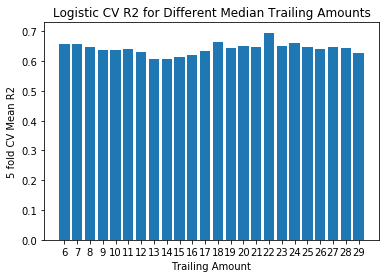

Trail Amt: 6, r2 Score: 0.6564
Trail Amt: 7, r2 Score: 0.6586
Trail Amt: 8, r2 Score: 0.6475
Trail Amt: 9, r2 Score: 0.6375
Trail Amt: 10, r2 Score: 0.6386
Trail Amt: 11, r2 Score: 0.6397
Trail Amt: 12, r2 Score: 0.6309
Trail Amt: 13, r2 Score: 0.6084
Trail Amt: 14, r2 Score: 0.6089
Trail Amt: 15, r2 Score: 0.6132
Trail Amt: 16, r2 Score: 0.6214
Trail Amt: 17, r2 Score: 0.6334
Trail Amt: 18, r2 Score: 0.6637
Trail Amt: 19, r2 Score: 0.6428
Trail Amt: 20, r2 Score: 0.6503
Trail Amt: 21, r2 Score: 0.6489
Trail Amt: 22, r2 Score: 0.6955
Trail Amt: 23, r2 Score: 0.6522
Trail Amt: 24, r2 Score: 0.6603
Trail Amt: 25, r2 Score: 0.6482
Trail Amt: 26, r2 Score: 0.6416
Trail Amt: 27, r2 Score: 0.6488
Trail Amt: 28, r2 Score: 0.6454
Trail Amt: 29, r2 Score: 0.6263

Best Score: 0.6955, Trail Amt: 22


In [208]:
display_results(trailAmtLst1, Scores1, 'Logistic', 'Median')

### Do same as above but change trailing function to mean

In [209]:
def trailAvg2(df, trailAmt, teams, team_fields, trailing_fields):
    final_df = df[['PrimKey', 'opptKey']]
    #compute trailing average
    counter = 0
    for i in teams:
        for j in [0,1]:
            temp = df[team_fields][df['teamAbbr']==i][df['Home']==j]
            for x in trailing_fields:
                temp[x+'_T'+str(trailAmt)] = temp[x].shift().rolling(window=trailAmt, min_periods = trailAmt).mean()
            if counter == 0:
                newDF = temp
            else:
                newDF = newDF.append(temp)
            counter = 1
        
    #create list with only trailing fields
    fields_t = [x for x in newDF.columns.tolist() if '_T' in x]
    fields_oppt = ['PrimKey','Win%'] + fields_t
    fields_team = ['PrimKey','MarginOfVictory', 'Home','Win?','teamDayOff_x','teamDayOff_y','Win%'] + fields_t
    
    #left join/merge with final nba sample which has only unique games with MoV, Home/Away, Days 
    df_final = final_df.merge(newDF[fields_team], how='left', left_on='PrimKey', right_on='PrimKey')
    df_final = df_final.merge(newDF[fields_oppt], how='left', left_on='opptKey',right_on='PrimKey')
    
    #remove nas and clean up duplicate columns/column names
    df_final.dropna(axis = 0, how='any', inplace=True)
    df_final.drop(columns='PrimKey_y', inplace=True)
    df_final.columns = df_final.columns.str.replace('PrimKey_x', 'PrimKey')
    df_final.reset_index(inplace=True,drop=True)
    
    #remove every other row
    home = 0
    away = 0
    for i in range(0,len(df_final),2):
        if home == away:
            df_final.drop(i,0,inplace=True)
            away += 1
        elif home < away:
            df_final.drop(i+1,0,inplace=True)
            home += 1
        elif home > away:
            df_final.drop(i,0,inplace=True)
            away += 1  
    df_final.reset_index(inplace=True,drop=True)
    

    return df_final

In [91]:
def trail_test2(df, trailAmtLst, teams, team_fields, trailing_fields):
    Scores = []
    for i in trailAmtLst:
        
        #print('TrailAmt: ',str(i))
        #create new trailing average subset
        new_trail_df = trailAvg2(df, i, teams, team_fields, trailing_fields)
        
        #create list of X_columns
        X_Cols = []
        X_Cols = [x for x in new_trail_df.columns.tolist() if '_x' in x or '_y' in x]
        X_Cols.append('Home')
        
        #scale x data
        X_PCA = scale_PCA(new_trail_df[X_Cols])

        #get cross-validated logistic score
        score = logisticReg(X_PCA, new_trail_df['Win?'], 5)
        
        #append results to lists
        Scores.append(score)
        
    #bestScore = max(bestScores) # get best score
    
    #print('Best trailAmt: {}, Score: {}'.format(trailAmtLst[bestScores.index(bestScore)],bestScore)) #print it
    
    return trailAmtLst, Scores

In [210]:
trailAmtLst2, Scores2 = trail_test2(nba_final, trailLst, teams, team_fields, trailing_fields)

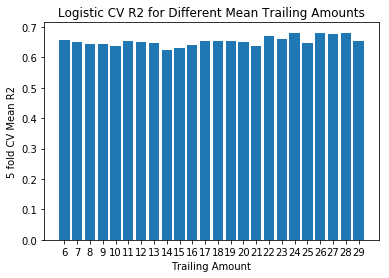

Trail Amt: 6, r2 Score: 0.6583
Trail Amt: 7, r2 Score: 0.6507
Trail Amt: 8, r2 Score: 0.6454
Trail Amt: 9, r2 Score: 0.6439
Trail Amt: 10, r2 Score: 0.6387
Trail Amt: 11, r2 Score: 0.6534
Trail Amt: 12, r2 Score: 0.6498
Trail Amt: 13, r2 Score: 0.6466
Trail Amt: 14, r2 Score: 0.6254
Trail Amt: 15, r2 Score: 0.6317
Trail Amt: 16, r2 Score: 0.6422
Trail Amt: 17, r2 Score: 0.6549
Trail Amt: 18, r2 Score: 0.6546
Trail Amt: 19, r2 Score: 0.6552
Trail Amt: 20, r2 Score: 0.6519
Trail Amt: 21, r2 Score: 0.6385
Trail Amt: 22, r2 Score: 0.6718
Trail Amt: 23, r2 Score: 0.6601
Trail Amt: 24, r2 Score: 0.6791
Trail Amt: 25, r2 Score: 0.646
Trail Amt: 26, r2 Score: 0.6796
Trail Amt: 27, r2 Score: 0.6767
Trail Amt: 28, r2 Score: 0.6812
Trail Amt: 29, r2 Score: 0.6532

Best Score: 0.6812, Trail Amt: 28


In [211]:
display_results(trailAmtLst2, Scores2, 'Logistic', 'Mean')

In [212]:
compare = pd.DataFrame()
compare['Trail_Amounts'] = trailAmtLst1
compare['Logistic_TrailingMedian'] = Scores1
compare['Logistic_TrailingMean'] = Scores2

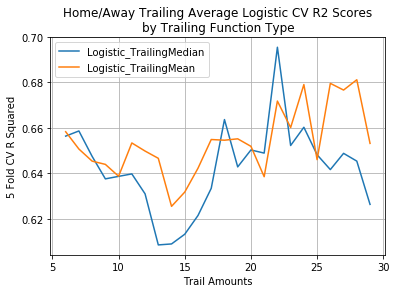

In [213]:
compare.plot(x='Trail_Amounts',kind='line', grid=True, title='Home/Away Trailing Average Logistic CV R2 Scores\nby Trailing Function Type')
plt.ylabel('5 Fold CV R Squared')
plt.xlabel('Trail Amounts')
plt.show()

In [214]:
#get coefficients from best model
df = trailAvg(nba_final, 22, teams, team_fields, trailing_fields)

In [215]:
X_Cols = [x for x in df.columns.tolist() if '_x' in x or '_y' in x]
X_Cols.append('Home')

In [232]:
X1 = df[X_Cols].astype(float)
scaler = StandardScaler()
X_S = scaler.fit_transform(X1)
pca1 = PCA(.95,svd_solver='full')
pca1.fit(X_S)
X_PCA = pca1.transform(X_S)

In [220]:
from sklearn.linear_model import LogisticRegressionCV

In [255]:
clf = LogisticRegressionCV(cv=5,penalty='l2', solver='lbfgs').fit(X_PCA, df['Win?'])

In [289]:
clf.coef_.shape

(1, 35)

In [238]:
comps = ['PC-' + str(x) for x in range(1,36)]

In [256]:
coef = pd.DataFrame(clf.coef_, columns=comps)

In [257]:
coef = coef.T

In [258]:
coef.columns=['log_coef']

In [259]:
coef['abs_log_coef'] = abs(coef['log_coef'])

In [260]:
coef.sort_values(['abs_log_coef'], ascending=False)

,log_coef,abs_log_coef
PC-4,0.238591,0.238591
PC-1,-0.238276,0.238276
PC-29,-0.234522,0.234522
PC-6,-0.207949,0.207949
PC-19,-0.191959,0.191959
PC-15,0.185539,0.185539
PC-28,-0.143252,0.143252
PC-27,0.132323,0.132323
PC-18,0.131848,0.131848
PC-17,-0.114571,0.114571


In [278]:
top_comps = coef.sort_values(['abs_log_coef'], ascending=False).index[:5].values.tolist()

### investigate the loadings of the top five highest abs coef, as they mattered more in determing outcome of game:
- PC 4
- PC 1
- PC 29
- PC 6
- PC 19

In [281]:
loadings = pd.DataFrame(pca1.components_,columns=X_Cols,index = comps)

In [282]:
loadings = loadings.T

In [283]:
top_comps_list = []
for i in top_comps:
    s = str(i)+'_abs'
    loadings[s] = abs(loadings[i])
    top_comps_list.append(s)
    top_comps_list.append(i)

In [285]:
loadings[top_comps_list].sort_values(['PC-4_abs'], ascending=False)

,PC-4_abs,PC-4,PC-1_abs,PC-1,PC-29_abs,PC-29,PC-6_abs,PC-6,PC-19_abs,PC-19
teamTRB_T22_x,0.288674,0.288674,0.054699,-0.054699,0.060278,-0.060278,0.147928,0.147928,0.093684,-0.093684
teamORB_T22_x,0.248625,0.248625,0.008282,0.008282,0.016125,-0.016125,0.180742,0.180742,0.187980,0.187980
teamOREB%_T22_x,0.209105,0.209105,0.030794,-0.030794,0.064562,-0.064562,0.171188,0.171188,0.188040,0.188040
teamTRB_T22_y,0.202451,-0.202451,0.065059,0.065059,0.143712,-0.143712,0.065200,-0.065200,0.061172,-0.061172
teamDRB_T22_x,0.200722,0.200722,0.073367,-0.073367,0.017712,-0.017712,0.037099,0.037099,0.240428,-0.240428
teamORB_T22_y,0.195551,-0.195551,0.035753,-0.035753,0.042755,0.042755,0.088982,-0.088982,0.247798,0.247798
teamOREB%_T22_y,0.192288,-0.192288,0.017487,0.017487,0.036092,0.036092,0.042444,-0.042444,0.206088,0.206088
teamTREB%_T22_x,0.189745,0.189745,0.093120,-0.093120,0.087059,-0.087059,0.074663,0.074663,0.005180,0.005180
teamFGA_T22_x,0.180754,0.180754,0.010200,-0.010200,0.095880,-0.095880,0.172914,0.172914,0.045053,0.045053
teamAR_T22_y,0.172167,0.172167,0.130480,0.130480,0.045746,0.045746,0.143740,-0.143740,0.050102,-0.050102
